# Covid-19 Radiology Segmentation & Classification
COMP 478 Project
<br>
Jeremy Gaudet
<br>
ID: 40045224
<br>
April 25, 2021

In [23]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import scipy.ndimage as ndimage
from keras.preprocessing.image import ImageDataGenerator,array_to_img
import pandas as pd
import numpy as np
from tensorflow.python.keras.utils.vis_utils import plot_model
import os
from tqdm.keras import TqdmCallback

Uncomment the following code cell if running on Google Colab.
The link to download the dataset is included in this cell.

In [24]:
# import sys
# !curl -O https://www.kaggle.com/tawsifurrahman/covid19-radiography-database/download
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/COMP478 Project/')
# %cd /content/gdrive/My Drive/COMP478 Project/

### Global variables

You will need to change the PATH variable to point to the unzipped folder COVID-19_Radiography_Dataset

In [25]:
PATH = '/Users/jeremygaudet/Developer/data/COVID-19_Radiography_Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
IMAGE_WIDTH = IMAGE_SIZE[0]
IMAGE_HEIGHT = IMAGE_SIZE[1]
EPOCHS = 3

### Load the images

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=1373,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=1373,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


# DATA ANALYSIS

In this dataset, the chest x-ray images are divided into four classes:

In [28]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(CLASS_NAMES)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


The number of images in each class, however, is not evenly distrubuted, as can be seen in the following tables and graph. The biggest difference is between 'Viral Pneumonia' and 'Normal', where the latter has almost eight times as many instances as the former.

In [29]:
# # Get all training and validation labels and put them into separate lists
# # NOTE This can take a while
training_labels = np.concatenate([y for x, y in train_ds], axis=0)
validation_labels = np.concatenate([y for x, y in val_ds], axis=0)

In [30]:
# Use pandas to store the image count of each class in the training set
unique, counts = np.unique(training_labels, return_counts=True)
train_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])
# Do the same for validation set
unique, counts = np.unique(validation_labels, return_counts=True)
val_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])

print('Distribution of training data:\n')
print(train_df)
print('\n\nDistribution of validation data:\n')
print(val_df)

Distribution of training data:

             class  image count
0            COVID         2898
1     Lung_Opacity         4819
2           Normal         8123
3  Viral Pneumonia         1092


Distribution of validation data:

             class  image count
0            COVID          718
1     Lung_Opacity         1193
2           Normal         2069
3  Viral Pneumonia          253


### Correction for the class weight

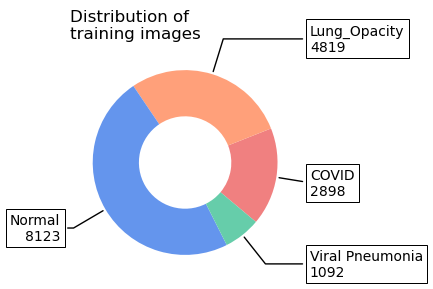

In [31]:
def display_distribution_donut(data_frame):
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"))

    categories = data_frame['class']
    img_count = data_frame['image count']

    wedges, texts = ax.pie(
        img_count, 
        wedgeprops=dict(width=0.5), 
        startangle=-40, 
        colors=['lightcoral','lightsalmon', 'cornflowerblue', 'mediumaquamarine'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f'{categories[i]}\n{img_count[i]}', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.title("Distribution of\ntraining images", loc='left')
    plt.show()

display_distribution_donut(train_df)

In [32]:
TRAIN_IMG_COUNT = train_df['image count'].sum()
weight_for_0 = (1 / train_df.loc[0, 'image count']) * (TRAIN_IMG_COUNT) / float(NUM_CLASSES)
weight_for_1 = (1 / train_df.loc[1, 'image count']) * (TRAIN_IMG_COUNT) / float(NUM_CLASSES)
weight_for_2 = (1 / train_df.loc[2, 'image count']) * (TRAIN_IMG_COUNT) / float(NUM_CLASSES)
weight_for_3 = (1 / train_df.loc[3, 'image count']) * (TRAIN_IMG_COUNT) / float(NUM_CLASSES)

CLASS_WEIGHTS = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print("Weight for class {}: {:.2f}".format(train_df.loc[0, 'class'], weight_for_0))
print("Weight for class {}: {:.2f}".format(train_df.loc[1, 'class'], weight_for_1))
print("Weight for class {}: {:.2f}".format(train_df.loc[2, 'class'], weight_for_2))
print("Weight for class {}: {:.2f}".format(train_df.loc[3, 'class'], weight_for_3))

Weight for class COVID: 1.46
Weight for class Lung_Opacity: 0.88
Weight for class Normal: 0.52
Weight for class Viral Pneumonia: 3.88


In [33]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 128, 128, 1)
(32,)


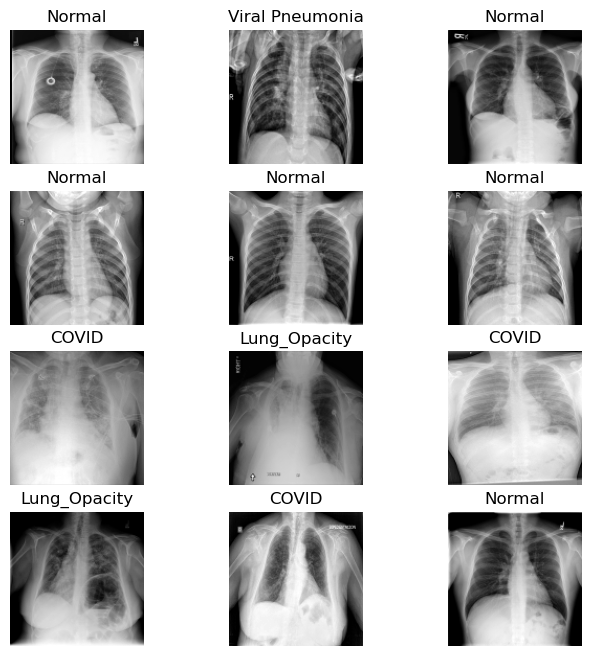

In [34]:
plt.figure(figsize=(8, 8))
for images, labels in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

# IMAGE PREPROCESSING

## Remove the diaphram from the images (the lower, bright area)

In [35]:
def segment_diaphram(images):
    # If blurred pixel-value is greater than 195, make it black; otherwise, do not alter
    # NOTE The commented out code below does a decent job, but threshold applies to entire batch
    # blurred_images = ndimage.gaussian_filter(images, sigma=3)
    # images = tf.where(blurred_images > 195, 0, images) 

    alist_images = []
    for img in images:
        blurred_image = ndimage.gaussian_filter(img, sigma=3)
        minimum, maximum, _, _ = ndimage.extrema(blurred_image)
        threshold = int((maximum - minimum) * 0.95 + minimum)
        img = tf.where(blurred_image > threshold, 16, img)
        alist_images.append(img)
    stack_of_imgs = np.stack(alist_images, axis=0)
    return stack_of_imgs

def tf_segment_diaphram(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(segment_diaphram, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

train_ds = train_ds.map(tf_segment_diaphram)

## Add randomly altered images to the training dataset

In [36]:
def reshape_image(image):
    image = tf.image.random_brightness(image, max_delta=.5)
    image = tf.image.random_contrast(image, .3, 1.7)
    image = tf.image.random_flip_left_right(image)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=3, dtype=tf.float32)
    image = tf.add(image, noise)
    return image

def tf_reshape_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(reshape_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

train_ds_reshaped = train_ds.map(tf_reshape_image)
train_ds = train_ds.concatenate(train_ds_reshaped)
train_ds.shuffle(buffer_size=len(train_ds)*BATCH_SIZE)

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Displaying some newly altered images

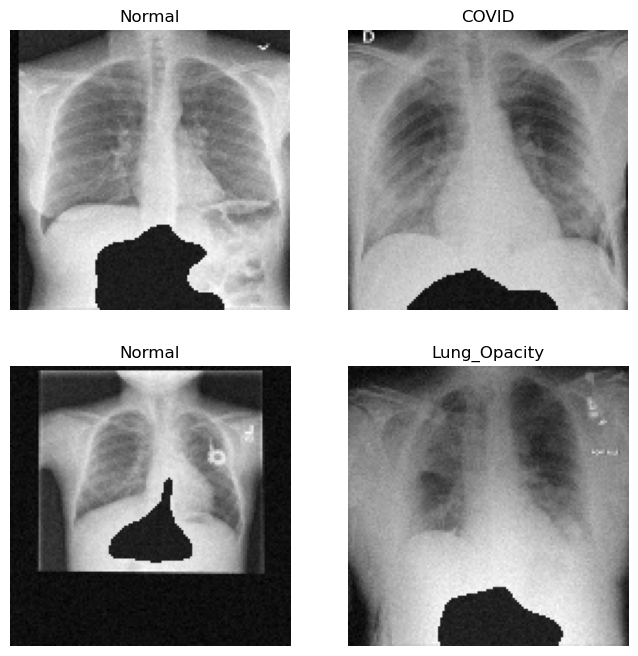

In [37]:
def show(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(CLASS_NAMES[label])
    plt.axis('off')

plt.figure(figsize=(8, 8))
for images, labels in train_ds_reshaped.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        img = images[i]
        img_gray = img[:,:,0]
        show(img_gray, labels[i])

## Using keras to add more random variation to the training set

In [38]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_HEIGHT, 
                                                              IMAGE_WIDTH,
                                                              1)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.01),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2,
                                                 width_factor=0.2),
  ]
)

### Display some changes that Keras made to the training set

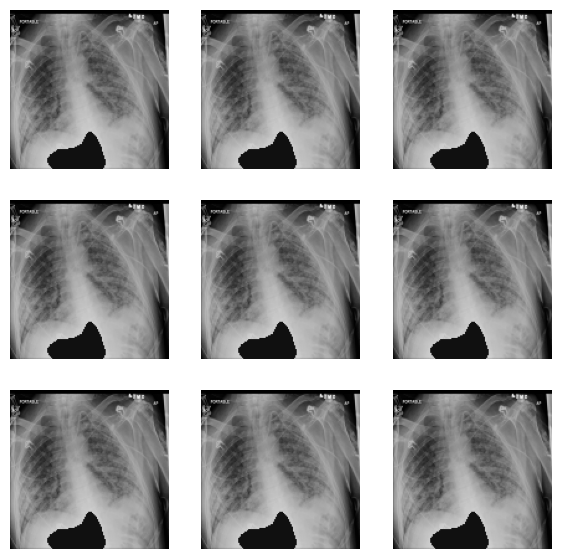

In [39]:
plt.figure(figsize=(7, 7))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        aug_img_gray = augmented_images[0,:,:,0]
        plt.imshow(aug_img_gray.numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

# CLASSIFICATION

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("models/covid-19_xray_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [42]:
model = tf.keras.Sequential([ 
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3,padding='same', activation='relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3,padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(NUM_CLASSES)
])

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()
# plot_model(model, to_file='./graphs/model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 1)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

In [44]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # NOTE I tried to include CLASS_WEIGHTS, but it causes a crash on my system after 2-3 epochs.
    # I have suffered many crashes with TensorFlow on my Mac M1, so I don't know if it's related to that.
    class_weight=CLASS_WEIGHTS,
    callbacks=[checkpoint_cb, early_stopping_cb],
    # verbose=0
)

Epoch 1/3
1060/1060 [==============================] - 232s 218ms/step - loss: 0.8230 - accuracy: 0.6107 - val_loss: 0.6714 - val_accuracy: 0.7196
Epoch 2/3
1060/1060 [==============================] - 204s 192ms/step - loss: 0.6696 - accuracy: 0.6819 - val_loss: 0.6147 - val_accuracy: 0.7394
Epoch 3/3
1060/1060 [==============================] - 205s 194ms/step - loss: 0.6013 - accuracy: 0.7162 - val_loss: 0.5868 - val_accuracy: 0.7505


# RESULTS

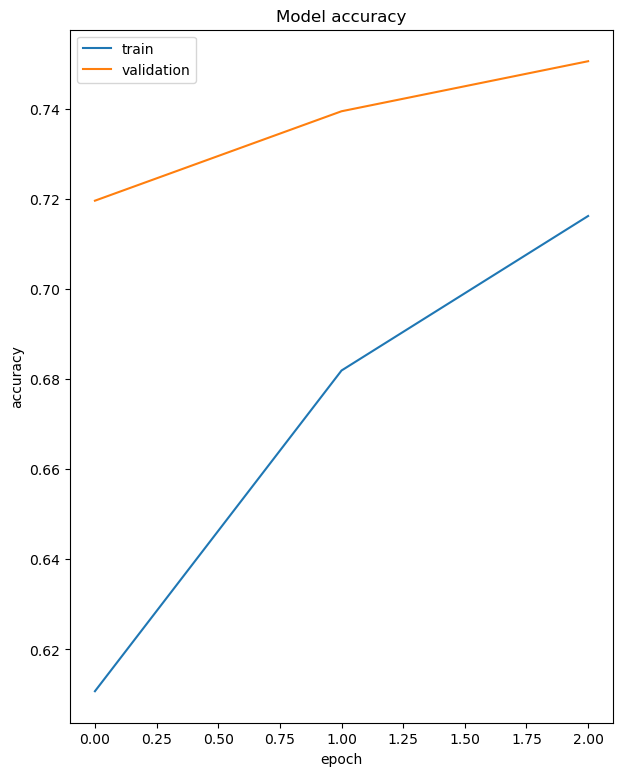

In [45]:
def plot_hist(hist):
    plt.figure(figsize=(7,9))
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

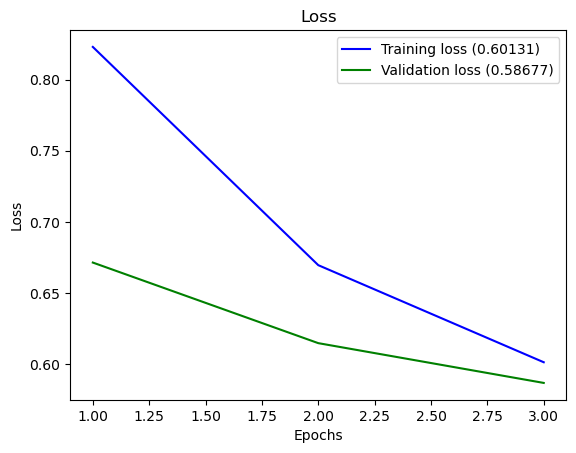

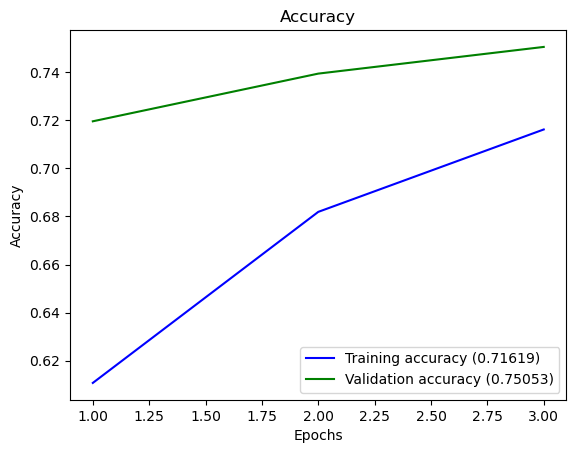

In [46]:
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    # As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    # Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(hist)


                  precision    recall  f1-score   support

          COVID       0.94      0.29      0.44       718
   Lung_Opacity       0.63      0.89      0.74      1193
         Normal       0.81      0.84      0.82      2069
Viral Pneumonia       0.96      0.70      0.81       253

       accuracy                           0.75      4233
      macro avg       0.83      0.68      0.70      4233
   weighted avg       0.79      0.75      0.73      4233



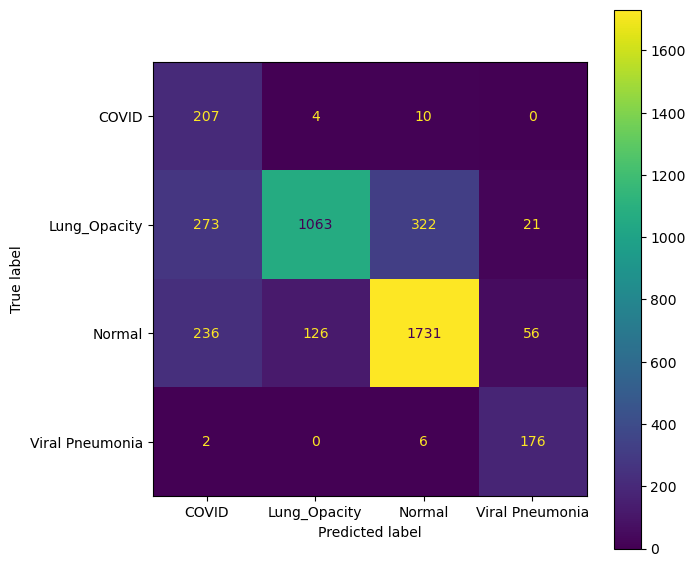

In [47]:
def validation_data_categories(test_images, model):
    y_pred = model.predict(test_images)
    predicted_cat = tf.argmax(y_pred, axis=1)
    true_cat = tf.concat([y for x, y in test_images], axis=0)
    return true_cat, predicted_cat

def plot_confusion_matrix(true_cat, predicted_cat):
    cm = confusion_matrix(predicted_cat, true_cat)
    display = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    fig, ax = plt.subplots(figsize=(7,7))
    display.plot(ax=ax)

# Show the confusion matrix and the report
true_cat, pred_cat = validation_data_categories(val_ds, model)
plot_confusion_matrix(true_cat, pred_cat)
print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

In [48]:
# # Save the model to a HDF5 file.
# !mkdir models/
# model.save('models/standard_128.h5')

# TESTING ON OUTSIDE DATA

In [49]:
if model is None:
    model = tf.keras.models.load_model('./models/standard_128.h5', compile=True)

In [50]:
import os

test_files = []
for (path, dirnames, filenames) in os.walk('./test_set/'):
    test_files.extend(os.path.join(path, name) for name in filenames if name != '.DS_Store')

print(test_files)

['./test_set/post-covid-lungs-coronavirus-brittany-kendall-600169deefed1__700.jpg', './test_set/respiratorial-bronchitis.jpg', './test_set/normal-lung-xray-15x10-by-Yale-Rosen.jpg', './test_set/viral-pneumonia.webp']


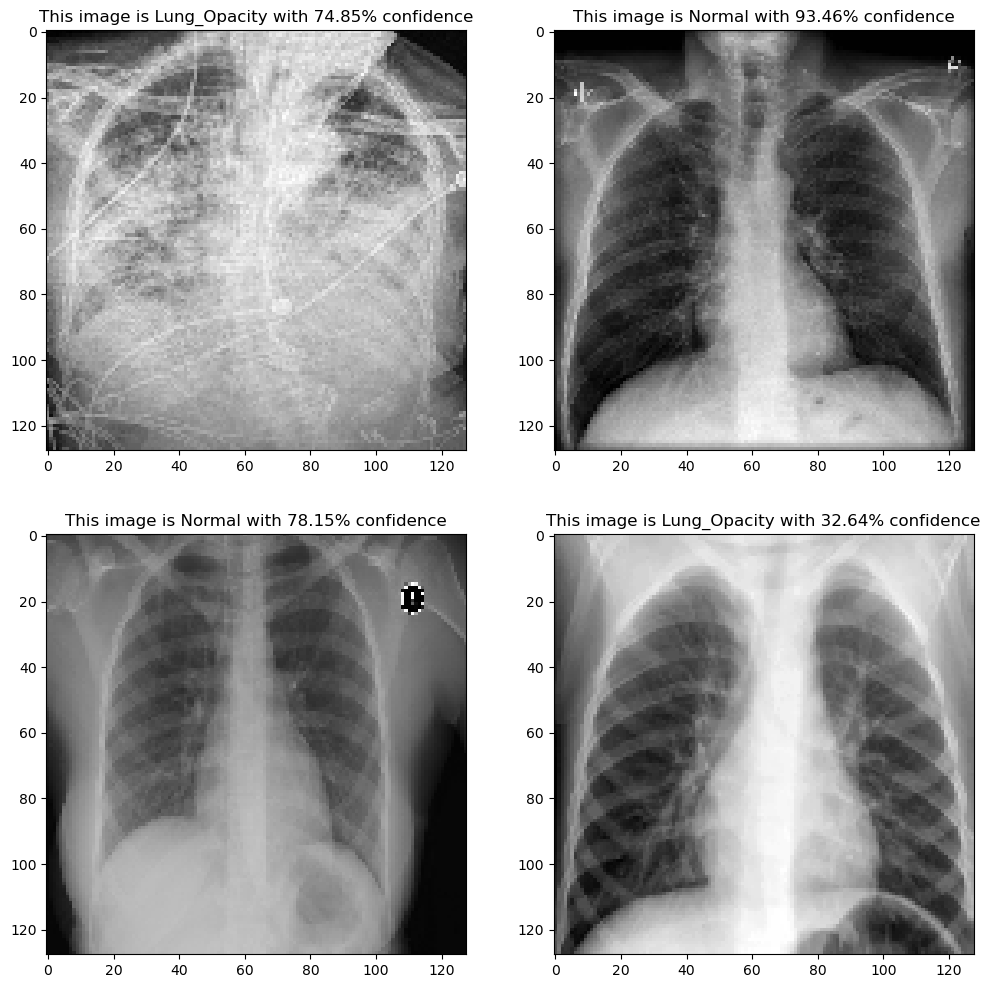

In [51]:
# Code cell is based on Tutorial #8

plt.figure(figsize=(12, 12))
for count, image_path in enumerate(test_files):
    img = keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), color_mode='grayscale')

    # Plot image
    ax = plt.subplot(2, 2, count + 1)

    # Preprocess image
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    # Make predictions on images
    predictions = model.predict(img_array)
    # score = predictions[-1]
    score = tf.nn.softmax(predictions[0])
    # Get index for highest confidence class
    idx = np.argmax(score)
    plt.title(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')
    plt.imshow(img, cmap='gray')

For a single image

This image is Normal with 78.15% confidence


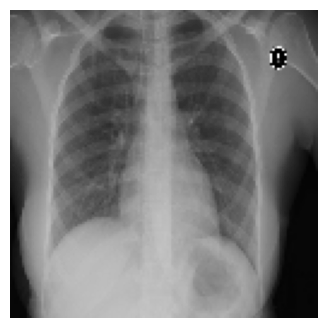

In [59]:
test_image_path = 'test_set/normal-lung-xray-15x10-by-Yale-Rosen.jpg'
# test_image_path = "test_set/viral-pneumonia.webp"

img = keras.preprocessing.image.load_img(test_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), color_mode='grayscale')

# Plot image
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap='gray')
plt.axis("off")

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
# score = predictions[-1]
score = tf.nn.softmax(predictions[0])
idx = np.argmax(score)

print(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')

For a large dataset classified by directory

In [53]:
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     './test_directory', # At the moment empty. Place your dataset here in files grouped by class
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     label_mode="int",
#     color_mode="grayscale"
# )

# if model is None:
#     model = tf.keras.models.load_model('models/standard_128.h5', compile=True)

# true_cat, pred_cat = validation_data_categories(test_ds, model)
# plot_confusion_matrix(true_cat, pred_cat)
# print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

# APPENDIX

This code was used to create some graphs in the report. It does not need to be run.

In [54]:
# amount0 = {}
# amount1 = {}
# amount2 = {}
# amount3 = {}
# for img, label in train_ds:
# #  print(features[0])
#     for i in range(len(label)):
#         # flat_img = img[i].numpy().flatten()
#         # print(flat_img)
#         # print(len(flat_img))
#         # print(len(label))
#         avg = int(np.average(img[i]))
#         # avg = int(np.sum(flat_img) / len(flat_img))
#         # print(label)
#         if label[i] == 0:
#             if avg not in amount0:
#                 amount0[avg] = 1
#             else:
#                 amount0[avg] += 1
#         elif label[i] == 1:
#             if avg not in amount1:
#                 amount1[avg] = 1
#             else:
#                 amount1[avg] += 1
#         elif label[i] == 2:
#             if avg not in amount2:
#                 amount2[avg] = 1
#             else:
#                 amount2[avg] += 1
#         elif label[i] == 3:
#             if avg not in amount3:
#                 amount3[avg] = 1
#             else:
#                 amount3[avg] += 1

# sorted_dict0 = dict(sorted(amount0.items()))
# sorted_dict1 = dict(sorted(amount1.items()))
# sorted_dict2 = dict(sorted(amount2.items()))
# sorted_dict3 = dict(sorted(amount3.items()))

# plt.figure(figsize=(10,10))
# plt.plot(sorted_dict0.keys(), sorted_dict0.values(), 'red', label=CLASS_NAMES[0])
# plt.plot(sorted_dict1.keys(), sorted_dict1.values(), 'blue', label=CLASS_NAMES[1])
# plt.plot(sorted_dict2.keys(), sorted_dict2.values(), 'green', label=CLASS_NAMES[2])
# plt.plot(sorted_dict3.keys(), sorted_dict3.values(), 'black', label=CLASS_NAMES[3])
# plt.legend()
# plt.show()